In [1]:
import pandas as pd
print(f'pandas {pd.__version__}')
import numpy as np
print(f'numpy {np.__version__}')
import torch
print(f'torch {torch.__version__}')
from sklearn.preprocessing import minmax_scale, MinMaxScaler
import json
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt

from data_manip import remove_incomplete_days
from preproc import import_and_preprocess_data, create_and_add_datetime_features
from GAN import GAN
from plot import plot_losses
from plot import plot_synthetic_vs_real_samples

pandas 2.1.3
numpy 1.26.2
torch 2.1.1+cu121


##### Data preprocessing

In [21]:
path = Path().absolute().parent / 'GAN_data/all_load_profiles.json'
parquet_path = Path().absolute().parent / 'GAN_data/load_profiles.parquet.gzip'

if not parquet_path.exists():
    df_loadProfiles, log_dict = import_and_preprocess_data(path)
    df_loadProfiles = create_and_add_datetime_features(df_loadProfiles)

    with open(Path().absolute().parent / r'GAN_data/preproc_log.json', 'w') as file:
        json.dump(log_dict, file)
    df_loadProfiles.to_parquet(parquet_path, compression = 'gzip')

##### Data preparation

In [22]:
df_loadProfiles = pd.read_parquet(parquet_path)   #import data

df_loadProfiles = remove_incomplete_days(df_loadProfiles)

The following days were removed: ['2021-06-01', '2022-07-01']


In [24]:


profile = '16'

df_profile = df_loadProfiles[['date', 'hour of the day', profile]]
df_profile = df_profile.pivot_table(columns = 'hour of the day', index = 'date', values = profile)

labels = np.array(range(len(df_profile)))
samples = df_profile.to_numpy()

scaler = MinMaxScaler(feature_range = (-1, 1))
samplesScaled = scaler.fit_transform(samples.T).T

In [25]:


dataset = TensorDataset(torch.Tensor(samplesScaled), torch.Tensor(labels))
dataLoader = DataLoader(dataset)

##### Run GAN

In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU is used.')
else:
    device = torch.device('cpu')
    print('CPU is used.')

name = 'model_2023-11-21'
dimLatent = 32
featureCount = samplesScaled.shape[1]
classCount = len(set(labels))
dimEmbedding = classCount
lr = 1e-5
maxNorm = 1e6
epochCount = 5
testLabel = 0

GPU is used.


  0%|                                                                                   | 0/5 [00:00<?, ?it/s]

training: 0 %


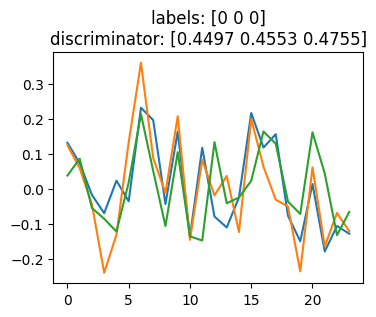

training: 10 %


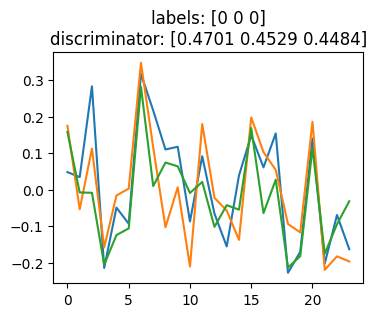

 20%|███████████████                                                            | 1/5 [00:02<00:08,  2.14s/it]

training: 20 %


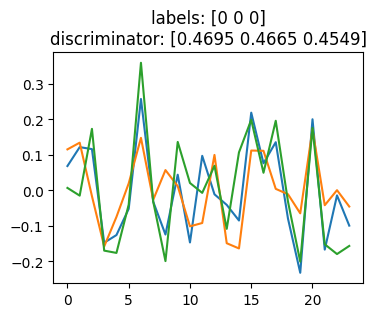

training: 30 %


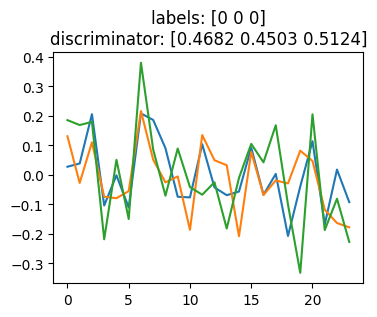

 40%|██████████████████████████████                                             | 2/5 [00:04<00:06,  2.08s/it]

training: 40 %


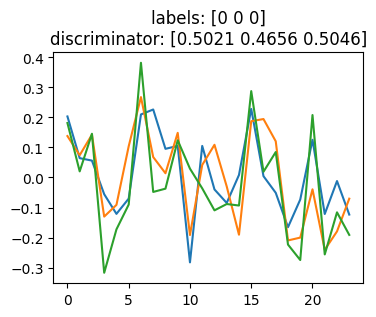

training: 50 %


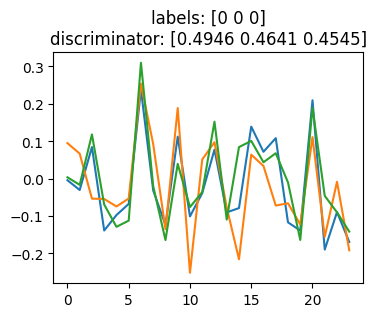

 60%|█████████████████████████████████████████████                              | 3/5 [00:06<00:04,  2.08s/it]

training: 60 %


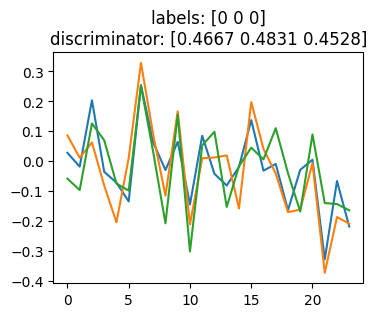

training: 70 %


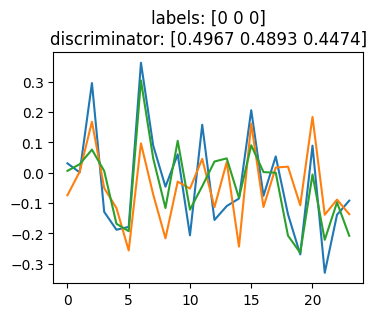

 80%|████████████████████████████████████████████████████████████               | 4/5 [00:08<00:02,  2.08s/it]

training: 80 %


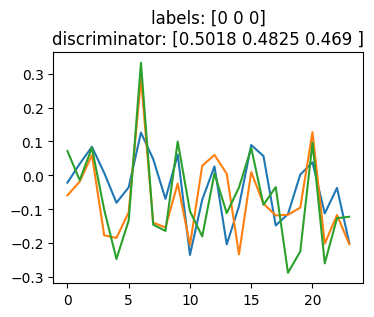

training: 90 %


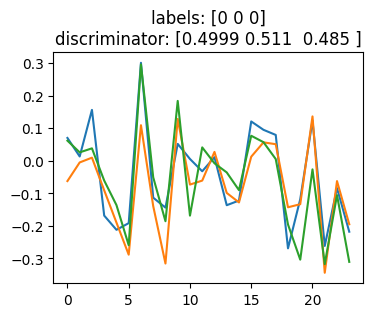

training: 99 %


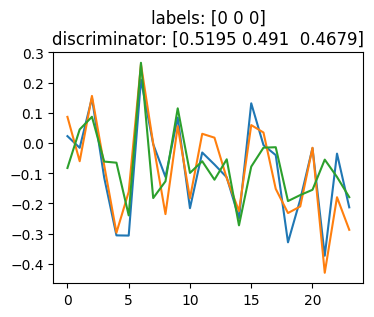

100%|███████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


In [32]:
model = GAN(
    name = name,
    device = device,
    dataLoader = dataLoader,
    dimLatent = dimLatent,
    featureCount = featureCount,
    classCount = classCount,
    dimEmbedding = dimEmbedding,
    lr = lr,
    maxNorm = maxNorm,
    epochCount = epochCount,
    testLabel = testLabel
)
model.train()

In [ ]:
featureCount

In [ ]:
plt.figure(figsize = (4, 3), facecolor = 'w')
plt.plot(samplesScaled[0]);

**Save model**

In [ ]:
torch.save(model, f'models/{model.name}.pt')

**Load model**

In [ ]:
model = torch.load('models/model_2023-11-15.pt')

##### Generate and visualize synthetic load profiles

In [ ]:
numberOfProfiles = 5

synthSamplesScaled_list = [model.generate_sample() for i in range(numberOfProfiles)]
synthSamples_list = [scaler.inverse_transform(item.T).T for item in synthSamplesScaled_list]

synthSamplesScaled = np.dstack(synthSamplesScaled_list)
synthSamples = np.dstack(synthSamples_list)

In [ ]:
plot_synthetic_vs_real_samples(
    model = model,
    df_profile = df_profile,
    samplesScaled = samplesScaled,
    synthSamples = synthSamplesScaled
)

In [ ]:
plot_losses(model = model)

### **Unfinished**

In [ ]:
plt.figure(figsize = (36, 12))
plt.plot(synthSamples.reshape(-1), color = 'green', label = 'Synthetic')
plt.legend(fontsize = 32)
plt.show()

In [ ]:
plt.figure(figsize = (30, 12), facecolor = 'w')
plt.plot(samples.reshape(-1))
plt.title('Real profile', fontsize = 24)
plt.savefig('plots/test_model_2023-11-15/real_load_profile.png')
plt.close();

plt.figure(figsize = (30, 12), facecolor = 'w')
plt.plot(synthSamples.reshape(-1, 5), linewidth = 0.25, alpha = 0.5, label = range(synthSamples.shape[2]))
plt.title('Synthetic profiles', fontsize = 24)
plt.legend( title = 'Profile')
plt.savefig('plots/test_model_2023-11-15/synthetic_load_profiles.png')
plt.close();